# Notebook relatif à l'article "Real-Time Seamless Single Shot 6D Object Pose Prediction"#

Par Simon HERBECQ et Pierrick HAUMESSER

Dans ce notebook, on se propose de reproduire les expériences faites par l'équipe de rechercher relative à cet article.


On va

In [1]:
#Import des bibliothèques utilent : 

import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

### Création du modèle ###

In [2]:
#Code du CNN : 

C = 8 #Nombre de classe à prédire

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation = 'relu',input_shape=(416,416,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(256,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(512,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(1024,(3,3),activation = 'relu'))
model.add(layers.Conv2D(1024,(3,3),activation = 'relu'))
model.add(layers.Conv2D((9*2+1+C),(1,1),activation = 'relu'))

In [3]:
#On fait un résumer du CNN 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 414, 414, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 207, 207, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 205, 205, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 102, 102, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 256)       2

Pour pouvoir faire des prédictions, on ajoute des couches denses :

In [3]:
model.add(layers.Flatten())
model.add(layers.Dense(units = 8, activation = 'softmax'))

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 414, 414, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 207, 207, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 205, 205, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 102, 102, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 256)       2

In [5]:
#On compile le modèle : 

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Preprocessing des datas ###

Le dataset "OCCLUSION" contient des images de 8 objets : 
- Bakingpan (plaque de cuisson)
- Pitcher (cruche)
- Shaker 
- Scissors (cisseaux)
- Thermos 
- Colander (passoir)
- Saucepan (casserole)
- Cup (tasse)

#### Exemple de la réduction d'une image ####

On veut mettre les images au format 416x416, qui est la taille d'entrée du CNN :

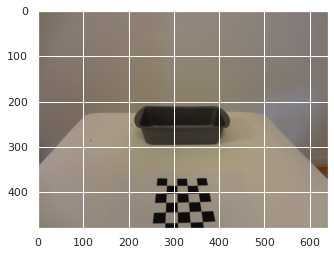

In [6]:
#Loading d'une image

sns.set(color_codes = True)
image = cv2.imread('/home/pierrick/Datasets/OCCLUSION/CMU_KO8/single/train/bakingpan/bakingpan.jpg')
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()

In [7]:
image.shape

(480, 640, 3)

Les images ne sont pas au bon format, il faut les mettre au bon format : (416x416)

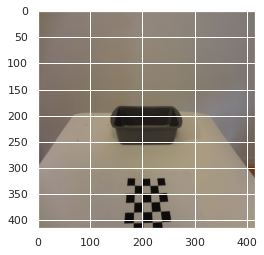

In [8]:
image_2 = cv2.resize(image,(416,416))
plt.imshow(cv2.cvtColor(image_2,cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
image_2.shape

(416, 416, 3)

#### Fonction permettant de faire la transformation sur tout le data set : ####

Entrée : 
- chemin : le direction vers les images

Sortie : 
- df : un dataframe pandas contenant les images, les targets sous la forme d'un vecteur et le nom de la target (labels)

In [6]:
def creation_df_pandas(chemin):
    data = {'image' : [],'target' : [], 'labels' : []}
    targets = os.listdir(chemin)
    k = 1
    for i in targets:
        direction = chemin + '/' + i
        fichier = os.listdir(direction)
        for file in fichier:
            if '.jpg' in file:
                image = cv2.imread(direction + '/' + file)
                image = cv2.resize(image,(416,416))
                data['image'] = data['image'] + [image]
                data['target'] = data['target'] + [(k-1)*[0]+[1]+(len(targets)-k)*[0]]
                data['labels'] = data['labels'] + [i]
        k = k +1
    df = pd.DataFrame(data=data)
    return(df)

### Entrainement du modèle ###

#### Entrainement sur les données simples ####

In [7]:
chemin = '/usr/users/gpusdi1/gpusdi1_26/Documents/AD/CMU_KO8/single/train/'
df_train = creation_df_pandas(chemin)

In [8]:
df_train

,image,target,labels
0,"[[[145, 161, 167], [146, 163, 166], [147, 164,...","[1, 0, 0, 0, 0, 0, 0, 0]",pitcher
1,"[[[77, 97, 103], [76, 95, 102], [78, 97, 104],...","[0, 1, 0, 0, 0, 0, 0, 0]",shaker
2,"[[[73, 94, 100], [73, 93, 98], [74, 94, 99], [...","[0, 0, 1, 0, 0, 0, 0, 0]",colander
3,"[[[70, 86, 93], [70, 86, 93], [71, 86, 94], [7...","[0, 0, 0, 1, 0, 0, 0, 0]",scissors
4,"[[[84, 106, 112], [83, 105, 111], [84, 106, 11...","[0, 0, 0, 0, 1, 0, 0, 0]",saucepan
5,"[[[1, 20, 118], [1, 23, 121], [2, 24, 122], [4...","[0, 0, 0, 0, 0, 1, 0, 0]",cup
6,"[[[85, 106, 114], [85, 106, 114], [86, 106, 11...","[0, 0, 0, 0, 0, 0, 1, 0]",bakingpan
7,"[[[11, 11, 17], [11, 11, 17], [11, 12, 17], [1...","[0, 0, 0, 0, 0, 0, 0, 1]",thermos


In [9]:
#On transforme une série Pandas en un array numpy pour l'entrée du réseau à convolution

train_images = df_train['image']
train_images = train_images.values.tolist()
train_images = np.array(train_images)

train_labels = df_train['target']
train_labels = train_labels.values.tolist()
train_labels = np.array(train_labels,dtype='uint8')

On load les données de test : 

In [10]:
df_test = creation_df_pandas('/usr/users/gpusdi1/gpusdi1_26/Documents/AD/CMU_KO8/single/test/')

In [12]:
test_images = df_test['image']
test_images = test_images.values.tolist()
test_images = np.array(test_images)

test_labels = df_test['target']
test_labels = test_labels.values.tolist()
test_labels = np.array(test_labels,dtype='uint8')

On normalise les images entre 0 et 1 pour améliorer les temps de calculs

In [13]:
train_images = train_images / 255
test_images = test_images / 255

In [14]:
history = model.fit(train_images, train_labels, epochs=100,validation_data = (test_images,test_labels))

Train on 8 samples, validate on 800 samples
Epoch 1/100
8/8 [==============================] - 4s 522ms/sample - loss: 2.0798 - accuracy: 0.0000e+00 - val_loss: 2.0892 - val_accuracy: 0.1250
Epoch 2/100
8/8 [==============================] - 2s 239ms/sample - loss: 2.0761 - accuracy: 0.1250 - val_loss: 2.1729 - val_accuracy: 0.1250
Epoch 3/100
8/8 [==============================] - 2s 233ms/sample - loss: 2.0713 - accuracy: 0.1250 - val_loss: 2.0959 - val_accuracy: 0.1238
Epoch 4/100
8/8 [==============================] - 2s 237ms/sample - loss: 2.0533 - accuracy: 0.2500 - val_loss: 2.3032 - val_accuracy: 0.1275
Epoch 5/100
8/8 [==============================] - 2s 236ms/sample - loss: 1.9285 - accuracy: 0.3750 - val_loss: 3.6613 - val_accuracy: 0.1287
Epoch 6/100
8/8 [==============================] - 2s 239ms/sample - loss: 1.5142 - accuracy: 0.5000 - val_loss: 7.6443 - val_accuracy: 0.1737
Epoch 7/100
8/8 [==============================] - 2s 238ms/sample - loss: 1.0012 - accuracy: 

Epoch 57/100
8/8 [==============================] - 2s 242ms/sample - loss: 5.9605e-07 - accuracy: 1.0000 - val_loss: 66.5335 - val_accuracy: 0.2300
Epoch 58/100
8/8 [==============================] - 2s 238ms/sample - loss: 8.4936e-07 - accuracy: 1.0000 - val_loss: 67.2715 - val_accuracy: 0.2288
Epoch 59/100
8/8 [==============================] - 2s 239ms/sample - loss: 1.1474e-06 - accuracy: 1.0000 - val_loss: 67.9927 - val_accuracy: 0.2275
Epoch 60/100
8/8 [==============================] - 2s 241ms/sample - loss: 1.4305e-06 - accuracy: 1.0000 - val_loss: 68.8837 - val_accuracy: 0.2250
Epoch 61/100
8/8 [==============================] - 2s 237ms/sample - loss: 1.8924e-06 - accuracy: 1.0000 - val_loss: 69.1146 - val_accuracy: 0.2262
Epoch 62/100
8/8 [==============================] - 2s 239ms/sample - loss: 2.1756e-06 - accuracy: 1.0000 - val_loss: 69.5646 - val_accuracy: 0.2275
Epoch 63/100
8/8 [==============================] - 2s 246ms/sample - loss: 2.6226e-06 - accuracy: 1.0000 

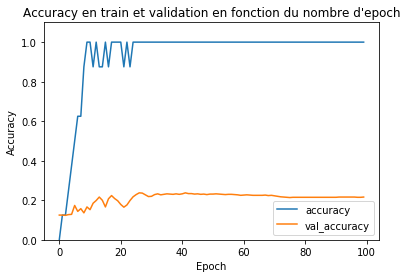

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.1])
plt.title("Accuracy en train et validation en fonction du nombre d'epoch")
plt.legend(loc='lower right')

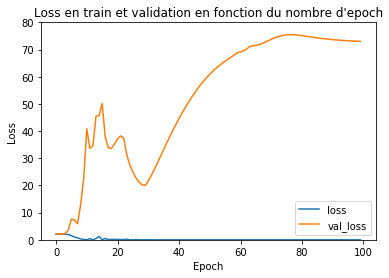

In [19]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 80])
plt.title("Loss en train et validation en fonction du nombre d'epoch")
plt.legend(loc='lower right')

Conclusion : Sur ces données d'entraînement le modèle overfit

#### Entrainement sur les données multiples ####

In [20]:
df_train = creation_df_pandas('/usr/users/gpusdi1/gpusdi1_26/Documents/AD/CMU_KO8/multiple/train/')

In [21]:
train_images = df_train['image']
train_images = train_images.values.tolist()
train_images = np.array(train_images)

train_labels = df_train['target']
train_labels = train_labels.values.tolist()
train_labels = np.array(train_labels,dtype='uint8')

In [22]:
df_test = creation_df_pandas('/usr/users/gpusdi1/gpusdi1_26/Documents/AD/CMU_KO8/multiple/test/')

In [23]:
test_images = df_test['image']
test_images = test_images.values.tolist()
test_images = np.array(test_images)

test_labels = df_test['target']
test_labels = test_labels.values.tolist()
test_labels = np.array(test_labels,dtype='uint8')

In [24]:
train_images = train_images / 255
test_images = test_images / 255

In [25]:
history = model.fit(train_images, train_labels, epochs=100,validation_data = (test_images,test_labels))

Train on 200 samples, validate on 800 samples
Epoch 1/100
200/200 [==============================] - 4s 18ms/sample - loss: 13.0717 - accuracy: 0.1900 - val_loss: 2.0852 - val_accuracy: 0.1250
Epoch 2/100
200/200 [==============================] - 3s 14ms/sample - loss: 2.0770 - accuracy: 0.1350 - val_loss: 2.1404 - val_accuracy: 0.1250
Epoch 3/100
200/200 [==============================] - 3s 15ms/sample - loss: 2.0999 - accuracy: 0.0400 - val_loss: 2.0789 - val_accuracy: 0.1250
Epoch 4/100
200/200 [==============================] - 3s 14ms/sample - loss: 2.0775 - accuracy: 0.1250 - val_loss: 2.1710 - val_accuracy: 0.1250
Epoch 5/100
200/200 [==============================] - 3s 14ms/sample - loss: 2.0849 - accuracy: 0.1250 - val_loss: 2.0795 - val_accuracy: 0.1250
Epoch 6/100
200/200 [==============================] - 3s 14ms/sample - loss: 2.0796 - accuracy: 0.1250 - val_loss: 2.0795 - val_accuracy: 0.1250
Epoch 7/100
200/200 [==============================] - 3s 14ms/sample - loss:

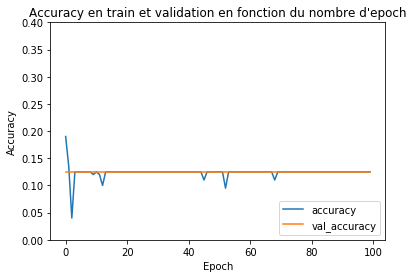

In [30]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 0.4])
plt.title("Accuracy en train et validation en fonction du nombre d'epoch")
plt.legend(loc='lower right')

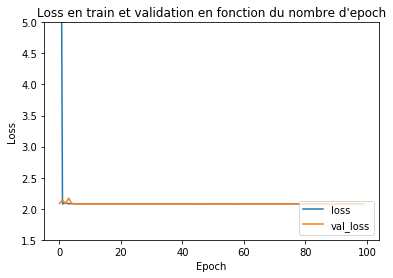

In [29]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([1.5, 5])
plt.title("Loss en train et validation en fonction du nombre d'epoch")
plt.legend(loc='lower right')

Conclusion : avec ces données la, le réseau underfit